In [185]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

First we read the data set

In [186]:
df = pd.read_csv('data/mushroom.csv')
df.head(5)

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,b'x',b's',b'n',b't',b'p',b'f',b'c',b'n',b'k',b'e',...,b'w',b'w',b'p',b'w',b'o',b'p',b'k',b's',b'u',b'p'
1,b'x',b's',b'y',b't',b'a',b'f',b'c',b'b',b'k',b'e',...,b'w',b'w',b'p',b'w',b'o',b'p',b'n',b'n',b'g',b'e'
2,b'b',b's',b'w',b't',b'l',b'f',b'c',b'b',b'n',b'e',...,b'w',b'w',b'p',b'w',b'o',b'p',b'n',b'n',b'm',b'e'
3,b'x',b'y',b'w',b't',b'p',b'f',b'c',b'n',b'n',b'e',...,b'w',b'w',b'p',b'w',b'o',b'p',b'k',b's',b'u',b'p'
4,b'x',b's',b'g',b'f',b'n',b'f',b'w',b'b',b'k',b't',...,b'w',b'w',b'p',b'w',b'o',b'e',b'n',b'a',b'g',b'e'


Looking at the data we can see that all categories are surrounded by the string "b''" so for clarity reasons we descided to remove this.

In [187]:
for col in df.columns:
    df[col] = df[col].str[1:]
df = df.replace({"'":""}, regex=True)
df.head(5)

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


Let's check if we need to fill any missing values

In [188]:
df.shape

(8124, 23)

In [189]:
df.count()

cap-shape                   8124
cap-surface                 8124
cap-color                   8124
bruises%3F                  8124
odor                        8124
gill-attachment             8124
gill-spacing                8124
gill-size                   8124
gill-color                  8124
stalk-shape                 8124
stalk-root                  8124
stalk-surface-above-ring    8124
stalk-surface-below-ring    8124
stalk-color-above-ring      8124
stalk-color-below-ring      8124
veil-type                   8124
veil-color                  8124
ring-number                 8124
ring-type                   8124
spore-print-color           8124
population                  8124
habitat                     8124
class                       8124
dtype: int64

We can see that each collumn has the same amount of values as the number of rows so we can conclude that there are no missing values we need to fill in.

Now we check the datatypes of each column.

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises%3F                8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

We can see that all features are objects (strings). So we will have to do one-hot encoding to make the categorical values useful for the models we want to train.

Now let's look at the distribution of the data to see if there are any weird things we need to know about.

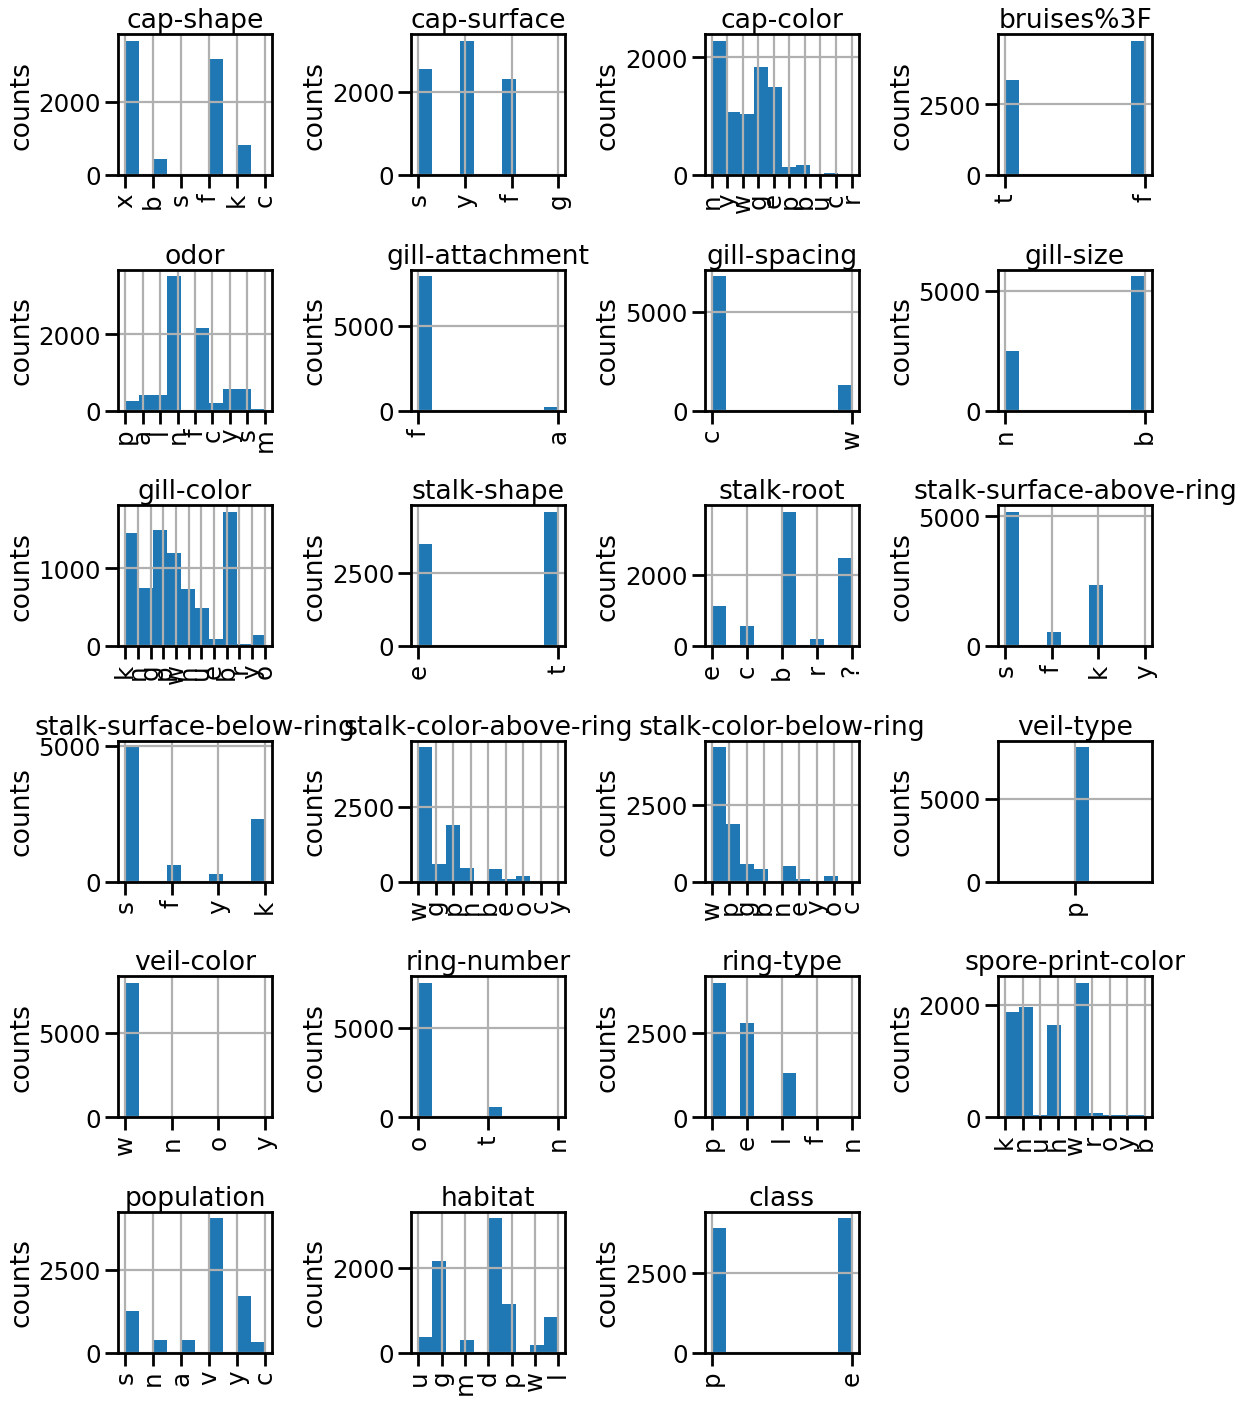

In [191]:
def show_distribution(dataframe):
  columnNames = list(dataframe)

  n = len(columnNames)

  row_count = 4

  plt.figure(figsize = (15, (n//row_count+1)*3), dpi = 80)
  for i in range(n):
      plt.subplot(n//row_count+1, row_count, i + 1)
      columnDf = dataframe.iloc[:, i]
      columnDf.hist()
      plt.ylabel('counts')
      plt.xticks(rotation = 90)
      plt.title(f'{columnNames[i]}')
  plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
  plt.show()

show_distribution(df)

Looking at the distribution of the data it seems that some data points have an unequal representation in the data. Luckily the class we are trying to predict has a almost 50/50 split in positive/negative distribution. But for data such as the gill-attachement, ring-number, veil-color and some others, one category in the data is severely underrepresented compared to others.

Now its time to one hot encode our data

In [192]:
def ohe(dataframe, cat_cols, cat_dictionary):
    df = dataframe.copy()
    for col in cat_cols:
        # Check if column is in the category dictionary
        
        # Get the list of categories for the column
        categories = cat_dictionary[col]
        
        # Create new column names for each category
        new_cols = [f"{col}_{c}" for c in categories]
        
        # One-hot encode the column
        one_hot = pd.get_dummies(df[col], prefix=col)
        
        # Add columns for any missing categories
        for c in new_cols:
            if c not in one_hot.columns:
                one_hot[c] = 0
        
        # Add the one-hot encoded columns to the dataframe
        df = pd.concat([df, one_hot], axis=1)
        
        # Drop the original column from the dataframe
        df.drop(columns=[col], inplace=True)
    
    return df



In [193]:
df_dict = df.to_dict(orient = 'list')
for key in df_dict.keys():
    df_dict[key] = list(set(df_dict[key]))

In [194]:
df_ohe = ohe(df, df.columns, df_dict)

For our classification predictions we will use a value of 1 to indicate a poisonous mushroom and a value of 0 to indicate an edible mushroom. So, to accomplish this we dropp the edible class collumn since we only need the poisonous class column which already contains the encoding we want.

In [195]:
df_ohe = df_ohe.drop("class_e", axis=1)

To see which variables might be important we can look at the correlation matrix

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,class_p
cap-shape_b,1.000000,-0.005387,-0.193260,-0.081769,-0.015264,-0.219564,-0.091638,0.018820,0.117712,-0.027947,...,-0.168381,-0.120154,-0.182037,0.149151,0.010113,0.374316,-0.095178,-0.052871,-0.037764,-0.182567
cap-shape_c,-0.005387,1.000000,-0.017672,-0.007477,-0.001396,-0.020077,-0.014032,0.249631,-0.015038,0.015893,...,-0.022075,-0.011469,-0.017653,-0.013306,0.065707,-0.004286,-0.008985,-0.004835,-0.003453,0.023007
cap-shape_f,-0.193260,-0.017672,1.000000,-0.268226,-0.050070,-0.720235,0.064801,-0.006285,-0.093397,0.029076,...,0.034625,0.111346,0.074986,-0.017982,-0.052326,-0.129312,0.021891,0.030636,-0.017450,0.018526
cap-shape_k,-0.081769,-0.007477,-0.268226,1.000000,-0.021185,-0.304733,-0.158942,0.010863,0.137988,0.015261,...,0.172707,-0.170081,-0.089230,-0.113404,0.235108,-0.065047,0.090538,-0.073380,0.119003,0.163565
cap-shape_s,-0.015264,-0.001396,-0.050070,-0.021185,1.000000,-0.056884,0.099464,-0.001396,-0.042607,-0.051272,...,0.000341,0.044603,-0.050018,-0.037702,-0.021242,-0.012142,-0.025458,0.288697,-0.009784,-0.060664
cap-shape_x,-0.219564,-0.020077,-0.720235,-0.304733,-0.056884,1.000000,0.063511,-0.020077,-0.040634,-0.019137,...,-0.060421,0.044626,0.071773,0.023197,-0.096639,-0.004529,-0.029042,0.002845,-0.036493,-0.026886
cap-surface_f,-0.091638,-0.014032,0.064801,-0.158942,0.099464,0.063511,1.000000,-0.014032,-0.428362,-0.515479,...,-0.116485,0.210552,0.190756,0.080694,-0.191987,-0.122077,-0.086727,-0.011913,-0.098365,-0.195415
cap-surface_g,0.018820,0.249631,-0.006285,0.010863,-0.001396,-0.020077,-0.014032,1.000000,-0.015038,-0.018096,...,-0.022075,-0.011469,-0.017653,-0.013306,0.065707,-0.004286,-0.008985,-0.004835,-0.003453,0.023007
cap-surface_s,0.117712,-0.015038,-0.093397,0.137988,-0.042607,-0.040634,-0.428362,-0.015038,1.000000,-0.552410,...,0.019574,-0.339696,-0.301670,0.123932,0.190799,0.077081,-0.039574,0.117548,0.062109,0.095454
cap-surface_y,-0.027947,0.015893,0.029076,0.015261,-0.051272,-0.019137,-0.515479,-0.018096,-0.552410,1.000000,...,0.089870,0.128418,0.110902,-0.191326,-0.006819,0.039697,0.117915,-0.100248,0.031986,0.088677


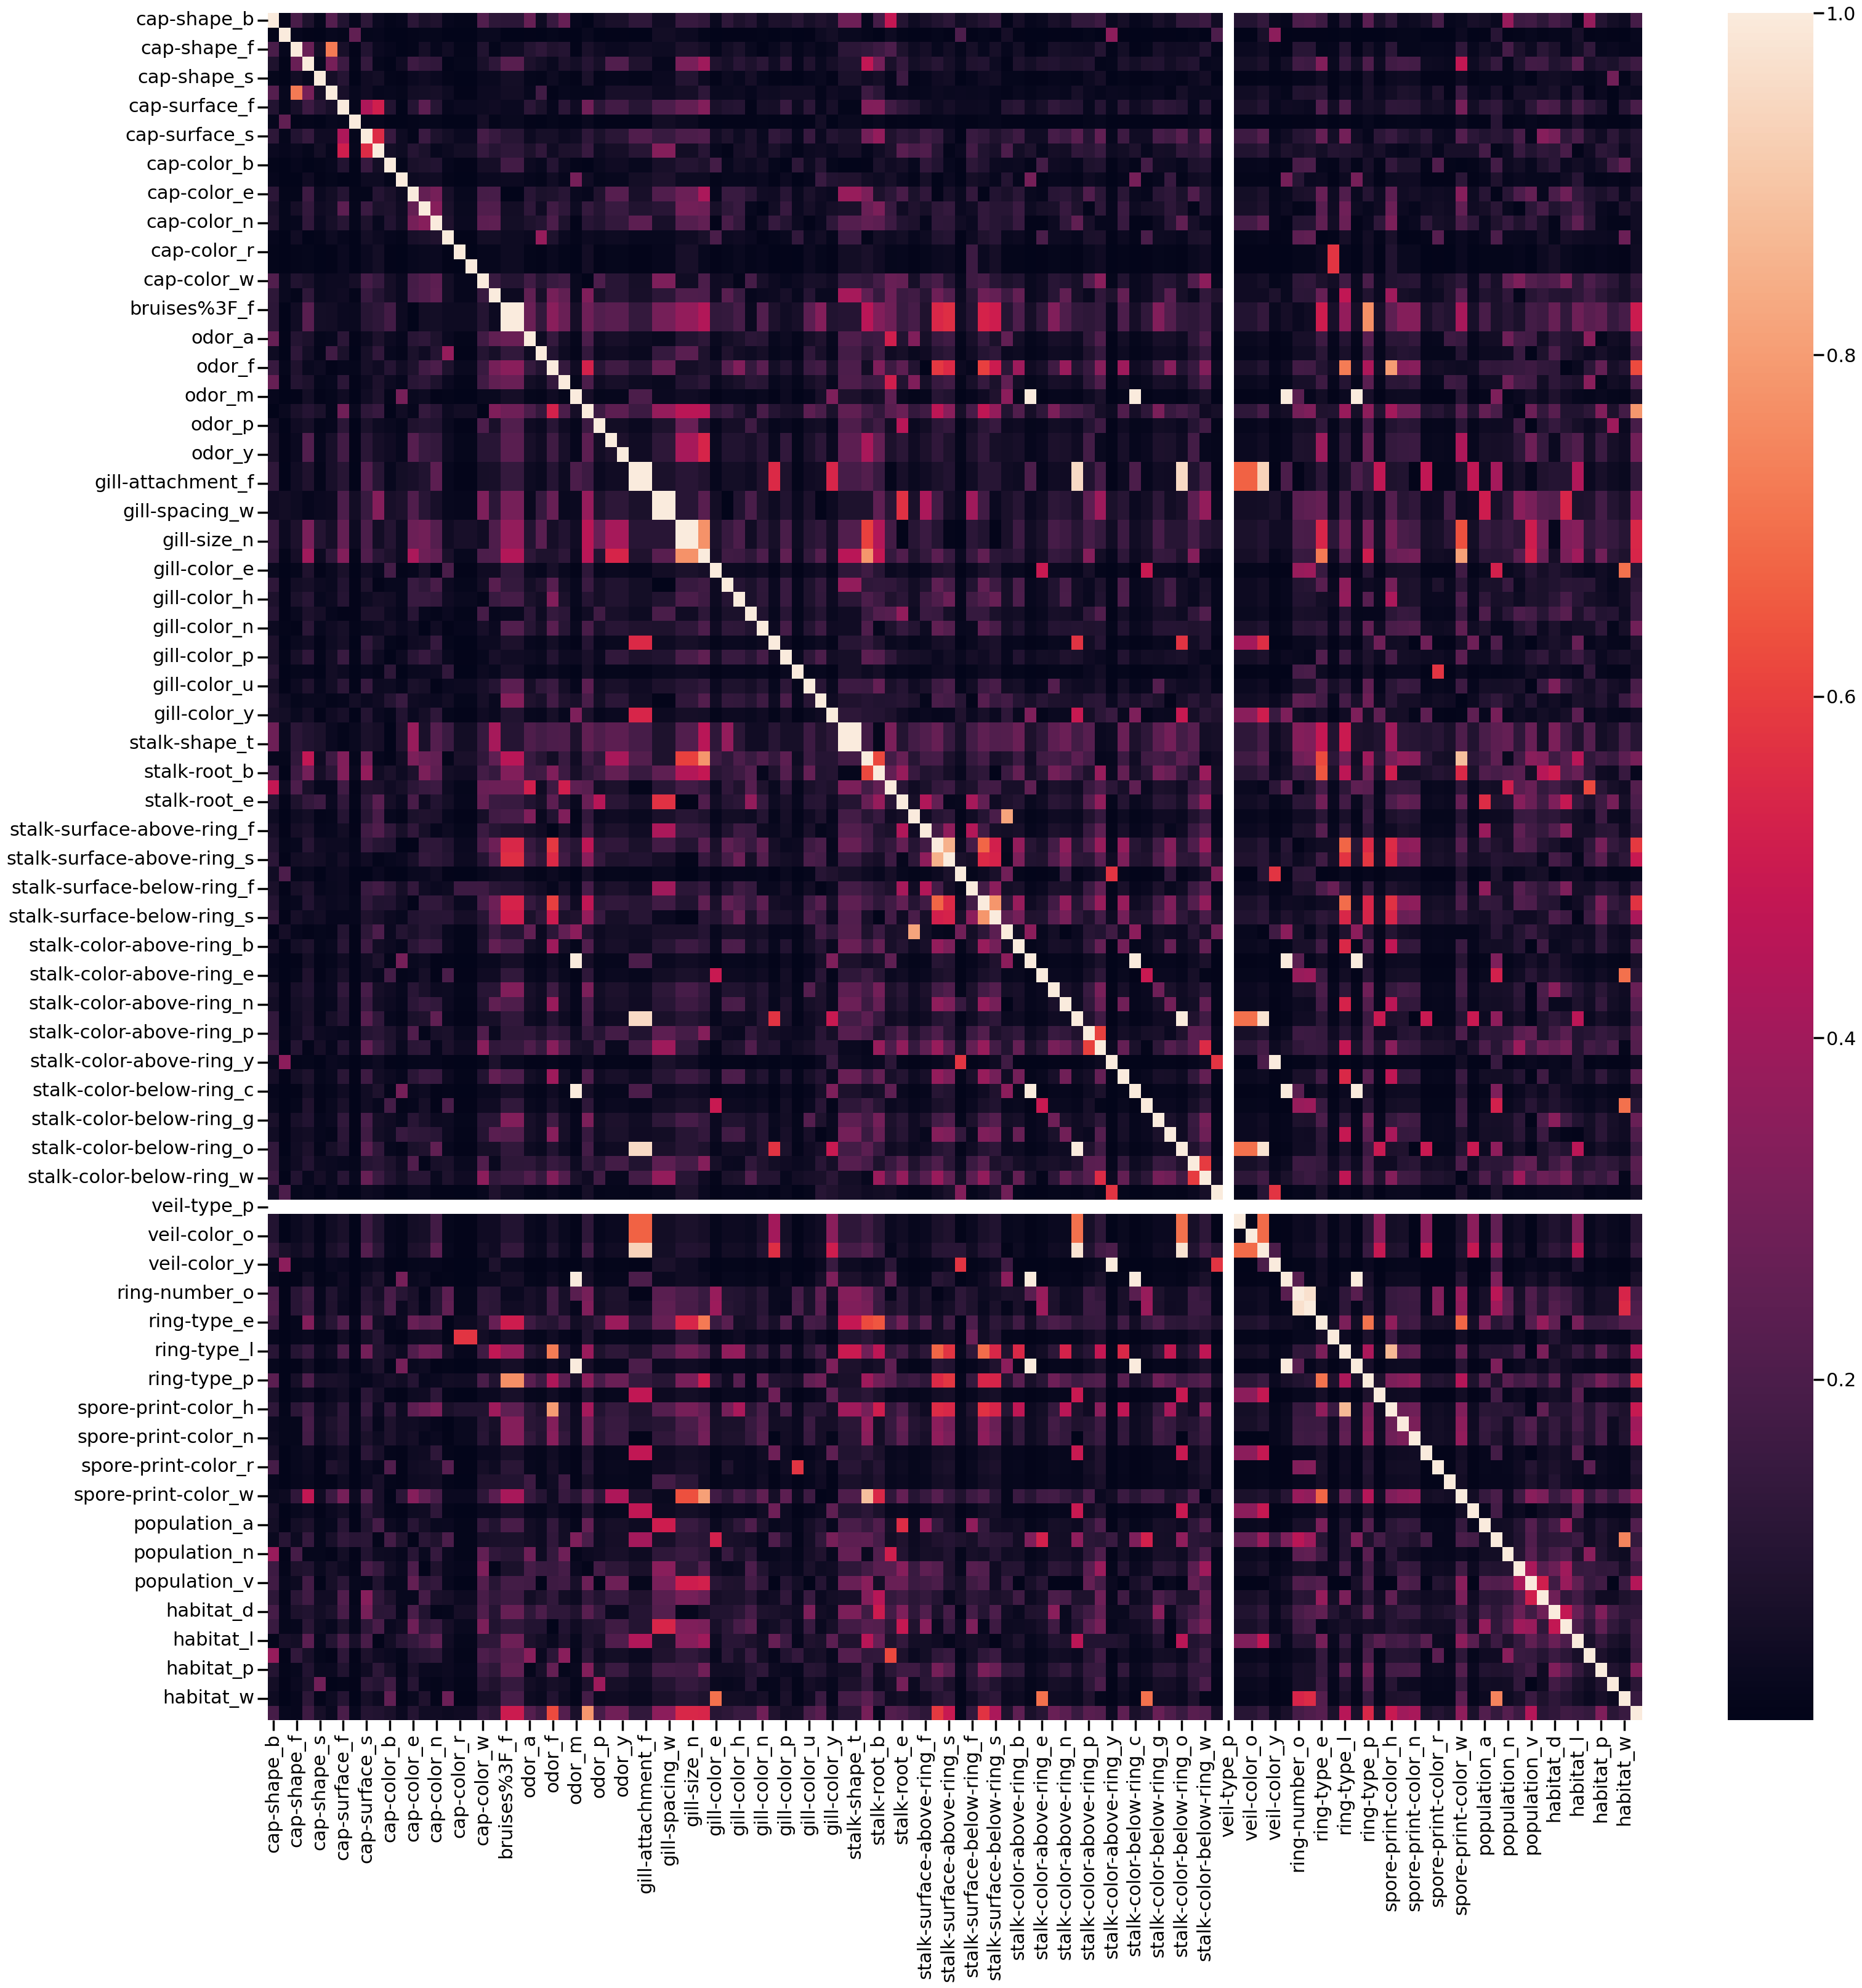

In [196]:
corr_matrix = df_ohe.corr()
fig, ax = plt.subplots(figsize = (36,36))
sns.heatmap(abs(corr_matrix))
pd.set_option('display.max_rows', None)


Here we can see that most variables have at most a small correlation between each other. We suspect that the few variables where a higher correlation can be seen might be due to the small representation of those categories in the data such as with the veil color and gill attachment categories. Furthermore, since the categories do not seem to be correlated with each other we can expect there to be no issues with multiple variables being dependant on each other.

In [197]:
high_c = corr_matrix[abs(corr_matrix['class_p']) > 0.5]['class_p']
print(high_c)

bruises%3F_f                  0.501530
bruises%3F_t                 -0.501530
odor_f                        0.623842
odor_n                       -0.785557
gill-size_b                  -0.540024
gill-size_n                   0.540024
gill-color_b                  0.538808
stalk-surface-above-ring_k    0.587658
stalk-surface-below-ring_k    0.573524
ring-type_p                  -0.540469
class_p                       1.000000
Name: class_p, dtype: float64


Specifically looking at the correlation between the class we want to predict and the features we can see a few features with more correlation than others. Especially the odor seems to have a hight correlation.

In [198]:
X = df_ohe
y = df_ohe.pop("class_p")

Now its time to train our models

## Logisitc Regression 

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [200]:
train_acc = accuracy_score(y_pred_train, y_train)
test_acc = accuracy_score(y_pred, y_test)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 1.0
Testing accuracy: 1.0


In [201]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [202]:
from sklearn.metrics import confusion_matrix
threshold = 0.5
print(confusion_matrix(y_test,t_repredict(model, threshold, X_test)))
print(confusion_matrix(y_train,t_repredict(model, threshold, X_train)))

[[845   0]
 [  0 780]]
[[3363    0]
 [   0 3136]]


In [203]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

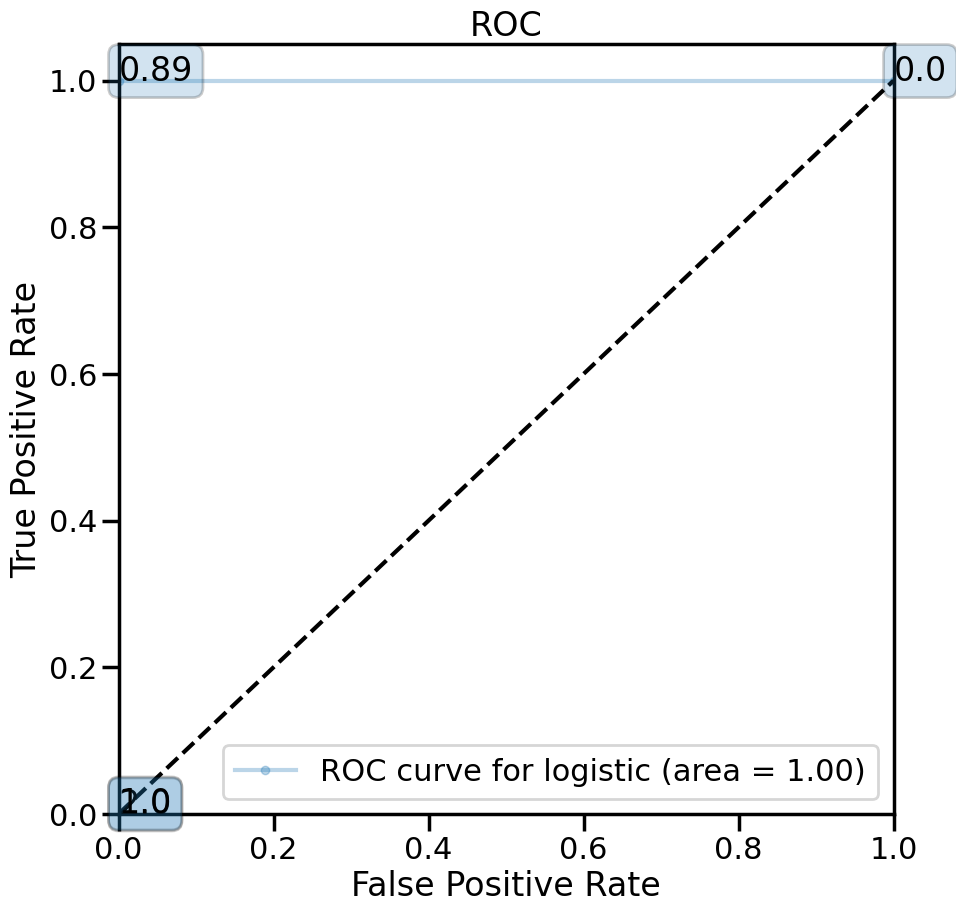

In [204]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",model, y_test, X_test, labe=1,  skip=0)
plt.show()

# Random Forest 


In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

RFmodel = RandomForestClassifier()

param_grid = {
    'n_estimators': [5, 10, 25],
    'max_depth': [None, 1, 5],
    'min_samples_split': [1, 2, 5]
}

grid_search = GridSearchCV(RFmodel, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 10}
Best score:  0.9466942781356575


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py", li

In [206]:
grid_search.best_params_

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 10}

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


RFmodel = RandomForestClassifier(**grid_search.best_params_)


RFmodel.fit(X_train, y_train)
y_pred = RFmodel.predict(X_test)

In [208]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [209]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [210]:
import time
start_time = time.time()
importances = RFmodel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFmodel.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.002 seconds


Using the random forest we can see which features are the most important

Text(0, 0.5, 'Mean decrease in impurity')

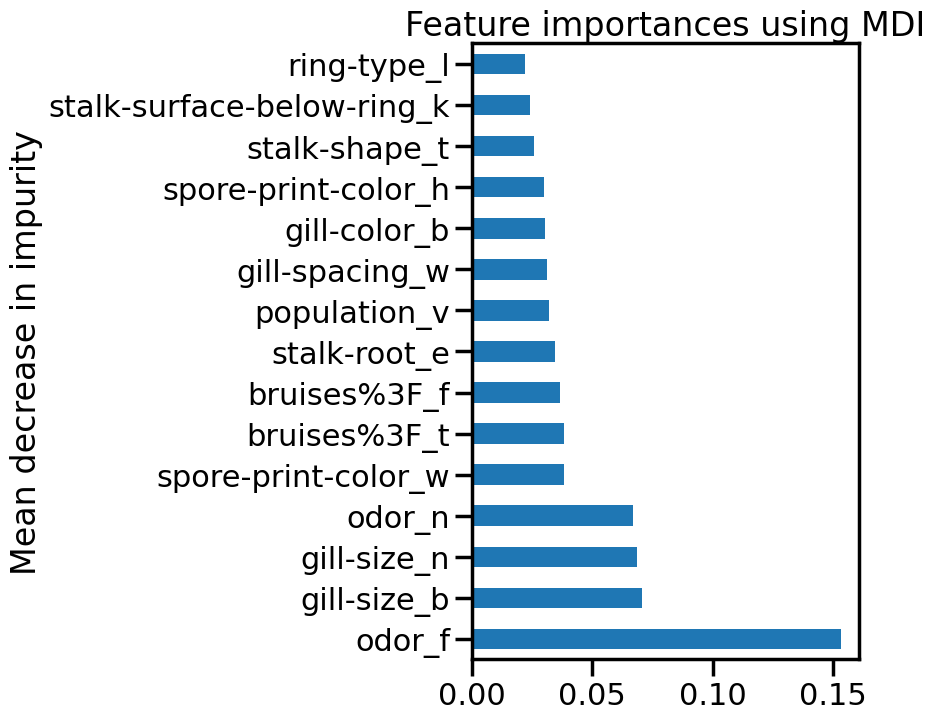

In [211]:
feature_names = [name for name in X.columns]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (5,8))
forest_importances.head(15).plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [212]:
feature_df = forest_importances.reset_index()
feature_df[['category', 'observation']] = feature_df['index'].str.split('_', n=1, expand=True)
feature_df = feature_df[['category', 'observation', 0]]
feature_df.columns = ['category', 'observation', 'value']


Text(0, 0.5, 'Mean decrease in impurity')

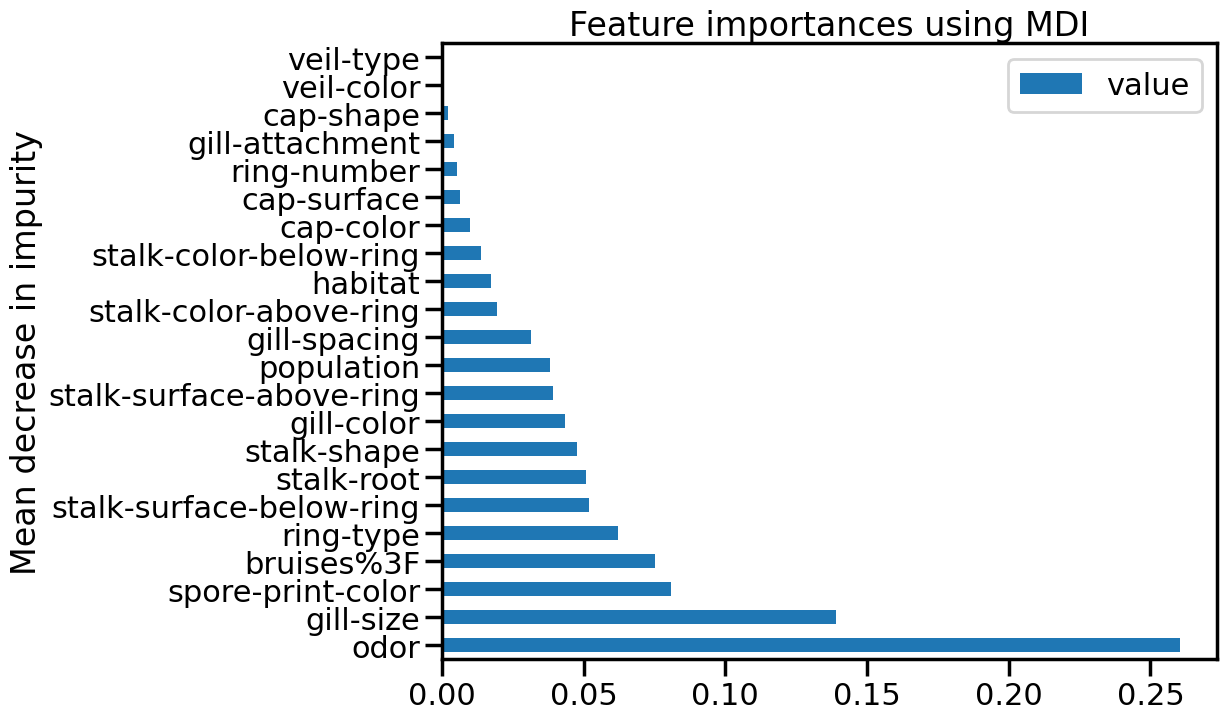

In [213]:
sorted_df = feature_df.groupby('category')['value'].sum().reset_index().sort_values('value', ascending=False)
sroted_df = sorted_df.set_index('category')
fig, ax = plt.subplots(figsize = (10,8))
sorted_df.plot.barh(x= 'category', y = 'value', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [214]:
sorted_df.set_index('category')

,value
category,
odor,0.260402
gill-size,0.139129
spore-print-color,0.080977
bruises%3F,0.075103
ring-type,0.062248
stalk-surface-below-ring,0.051853
stalk-root,0.050750
stalk-shape,0.047772
gill-color,0.043480


Looking at the feature importances we can see that the features we found in our exploration of the correlation matrix are mostly the same as the features that the random forest model deems most important.

# KNN

In [215]:
from sklearn.neighbors import KNeighborsClassifier

n = 5
knn_model = KNeighborsClassifier(n_neighbors=n)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_pred_train = model.predict(X_train)

In [216]:
train_acc = accuracy_score(y_pred_train, y_train)
test_acc = accuracy_score(y_pred, y_test)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 1.0
Testing accuracy: 1.0


# Reduced logisitic regression


Because we see that the odor is one of the most important features we wanted top explore the possibility of classifying the mushroom based on only the odor. Again we test this with different models

In [217]:
df_ohe = ohe(df, df.columns, df_dict)
X = df_ohe.loc[:,"odor_a":"odor_y"]
y = df_ohe["class_p"]

In [218]:
X.head(5)

,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y
0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0


In [219]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LogisticRegression(C=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [220]:
train_acc =accuracy_score(y_pred_train, y_train)
test_acc = accuracy_score(y_pred, y_test)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 0.9859116399945288
Testing accuracy: 0.9790897908979089


# Decision Tree Classifier

In [33]:
tree = DecisionTreeClassifier()

tree.fit(X=X_train,y=y_train)

y_pred_tree = tree.predict(X_test)


In [34]:
tree_train_acc =tree.score(X_train, y_train)
tree_test_acc = tree.score(X_test, y_test)

print("Training accuracy:", tree_train_acc)
print("Testing accuracy:", tree_test_acc)

Training accuracy: 1.0
Testing accuracy: 1.0


# PCA Analysis and Dimensionality Reduction

There are so many features for classifying mushrooms. If we wish to fit the dataset to new models, it may be smart to reduce the dimensionality of the dataset. We also do this to ensure that we avoid overfitting, and the curse of dimensionality. We have decided to use a PCA model on the dataset, as will follow:

In [162]:
pca = PCA()
X_PCA = pca.fit_transform(X_train)

We first want to determine how many principal components we wish to use. We can do this by plotting the variance porportions of each principal component. 

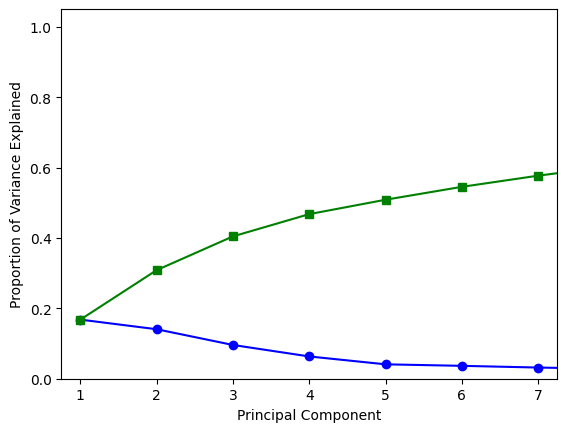

In [163]:
var_ratio = pca.explained_variance_ratio_
plt.plot(list(range(1, len(var_ratio) + 1)), var_ratio, '-o', color="blue", label='Individual component')
plt.plot(list(range(1, len(var_ratio) + 1)), np.cumsum(var_ratio), '-s', label='Cumulative', color="green")


plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,7.25)
plt.ylim(0,1.05)
plt.xticks(list(range(1, 8)))
plt.show()

The first 2 principal components hold about 35% of the variance, and may therefore be suitable for us to keep. 

In [191]:
pca = PCA(n_components = 3)
data_pca = pca.fit_transform(X_train)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])

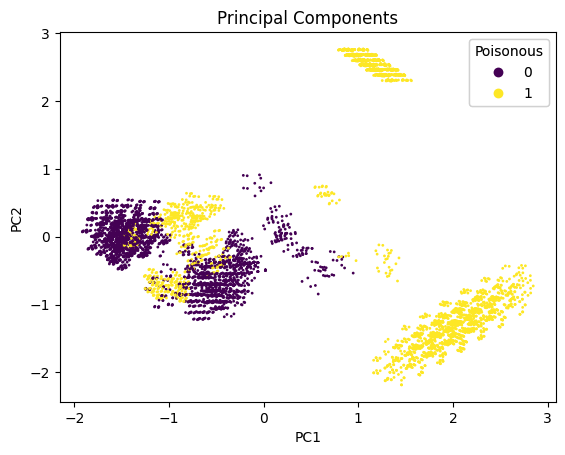

In [201]:

import matplotlib.pyplot as plt

x_plot = np.array(data_pca)[:,0]
y_plot = np.array(data_pca)[:,1]

fig, ax = plt.subplots()
scatter = ax.scatter(x=x_plot, y=y_plot, c=y_train,s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Principal Components')

legend = ax.legend(*scatter.legend_elements(), title="Poisonous")
ax.add_artist(legend)

plt.show()

The figure above depics the first principal component plotted against the second. Here we can see some distinct clusters, within the positive values and the negative values, indicating that there may be a clear distinction with our selected components. We can test the accuracy of our PCA model by using a K-nearest neighbors classifier.

In [196]:
from sklearn.neighbors import KNeighborsClassifier

data_pca_test = pca.fit_transform(X_test)
data_pca_test = pd.DataFrame(data_pca_test,columns=['PC1','PC2','PC3'])

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(data_pca,y_train)
training_acc = knn.score(data_pca,y_train)
testing_acc = knn.score(data_pca_test,y_test)

print("PCA model with 3 principal components")
print(f"Nearest Neighbor Classifier Training accuracy: {training_acc}")
print(f"Nearest Neighbor Classifier Testing accuracy: {testing_acc}")

PCA model with 3 principal components
Nearest Neighbor Classifier Training accuracy: 0.9973842129558393
Nearest Neighbor Classifier Testing accuracy: 0.9107692307692308


In [224]:
print('feature coefficients: ', model.coef_)
print('features: ', model.feature_names_in_)

feature coefficients:  [[-8.74208924  3.49349413  5.47881843 -8.7341875   2.17599466 -6.09142727
   3.70473632  4.35935774  4.36098543]]
features:  ['odor_a' 'odor_c' 'odor_f' 'odor_l' 'odor_m' 'odor_n' 'odor_p' 'odor_s'
 'odor_y']


# Reduced KNN


In [221]:
n = 5
knn_model = KNeighborsClassifier(n_neighbors=n)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_pred_train = model.predict(X_train)



In [222]:
train_acc = accuracy_score(y_pred_train, y_train)
test_acc = accuracy_score(y_pred, y_test)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 0.9859116399945288
Testing accuracy: 0.9790897908979089


So, we see that just by using the odor of the mushroom we are able to reach an accuraccy of about 98%. This is much more resonable and can possibly be used by a human if you learned which odors correspond to which class. Since only one odor is present for each mushroom we can look at the coefficients to see which odor has which effect. The output of the logistic regression is dependant on the result of the linear sum in the exponent. A positive result of linear sum in the exponent will result in a value of the sigmoid of 1 and a negative result of the exponent will result in a value of 0. Using this knowledge we can predict that the odor_a,odor_l,odor_n features indicate an edible mushroom and the others will be poisonous since the coefficients of the regression model are negative and positive respectively.

# Ethical considerations

There are many ethical implications of uasing machine learning on such a dataset. Sure, our model was able to correctly classify all of our instances, though we must consider if this is enough data for us to completely trust the model. There are of course repurcussions for blindly trusting such a model. In our case, if one were to consume a wrongly classified mushroom, this may result in death. For instance if our model overfits on this dataset, and we make new discoveries which the model is not able to classify correctly. Or if certain features are not available to us, and the model misclassifies an instance. From our data, we also discovered that the biggest factor in classifying poisnous mushrooms is the smell with 98% accuracy. Would it be smart to perhaps completely go off the smell of the mushrooms to determine if they are safe to consume? The biggest ethical concern of course, is if the model can cause harm to any individuals who have access to it. In our case, the misuse of the model can cause death. Therefore it is important for us to understand why our model behaves in the way it does, and it is important for us to perform exploratory data analysis on our models, so we may comprehend the effectiveness of the model. This not only applies to our specific problem, but bringing these ethical considerations into the real world, where machine learning is ubiquitous in our daily lives. 